# HFT - Intraday volatility estimation from high frequency data


**Lucas RODRIGUEZ**

*Academic work - October/November/December 2022*

In [2]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

In [3]:
# Filename & respective folder
data_folder = "data/"
source_filename = data_folder + "IVE_tickbidask.txt"

# Defining the columns names (explicit broadcast)
columns_name = ["Date", "Time", "Price", "Bid", "Ask", "Size"]

# Importing the main dataset
df = pd.read_csv(filepath_or_buffer=source_filename,
                names=columns_name,
                decimal=".",
                parse_dates={'dt' : ['Date', 'Time']}, 
                infer_datetime_format=True, 
                low_memory=False,
                index_col='dt')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10383278 entries, 2009-09-28 09:30:00 to 2022-10-28 16:00:00
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Price   float64
 1   Bid     float64
 2   Ask     float64
 3   Size    int64  
dtypes: float64(3), int64(1)
memory usage: 396.1 MB


> The order of the fields in the tick files (with bid/ask prices) is: **Date,Time,Price,Bid,Ask,Size**. Our bid/ask prices are recorded whenever a trade occurs and they represent the "national best bid and offer" (NBBO) prices across multiple exchanges and ECNs.

> For each trade, current best bid/ask values are recorded together with the transaction price and volume. Trade records are not aggregated and all transactions are included in their consecutive order.

> The order of fields in our regular tick files **(without bid/ask)** is: **Date,Time,Price,Size**.

*Source*: http://www.kibot.com/Support.aspx#tick_data_format

In [5]:
df.head(10)

,Price,Bid,Ask,Size
dt,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100
2009-09-28 09:30:00,50.71,50.70,50.79,638
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100


In [6]:
# Removing useless columns
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Bid', 'Ask', 'Size'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")

**References**:
1. https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [7]:
df.resample("H").mean().head(25)

,Price
dt,
2009-09-28 09:00:00,51.048208
2009-09-28 10:00:00,51.277057
2009-09-28 11:00:00,51.360257
2009-09-28 12:00:00,51.460638
2009-09-28 13:00:00,51.498606
2009-09-28 14:00:00,51.459281
2009-09-28 15:00:00,51.453001
2009-09-28 16:00:00,51.540000
2009-09-28 17:00:00,NaN


**Remark**: We can observe that the resampling operation creates a lot of NaN values, which corresponds to non-traded hours in our case. For these time slots, there is no existing records in the initial dataset, that's why the called aggregation method returns a NaN value.

We have to deal with these NaN values in order to successfully answer the given issue.

$\longrightarrow$ The best way to handle them is by:
1. **dropping the NaN rows** 
2. or by **replacing them by a specific value**



Since option 2 is not a relevant and reliable solution; it's non-sense to replace NaN values by any statistical indicator, since there is no market activity during these hours.

$\longrightarrow$ We choose to remove those elements.

**Reference**:
1. https://stackoverflow.com/questions/44770839/resampling-a-pandas-dataframe-by-business-days-gives-bad-results
2. https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
3. https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offset-semantics
4. https://stackoverflow.com/questions/44770839/resampling-a-pandas-dataframe-by-business-days-gives-bad-results

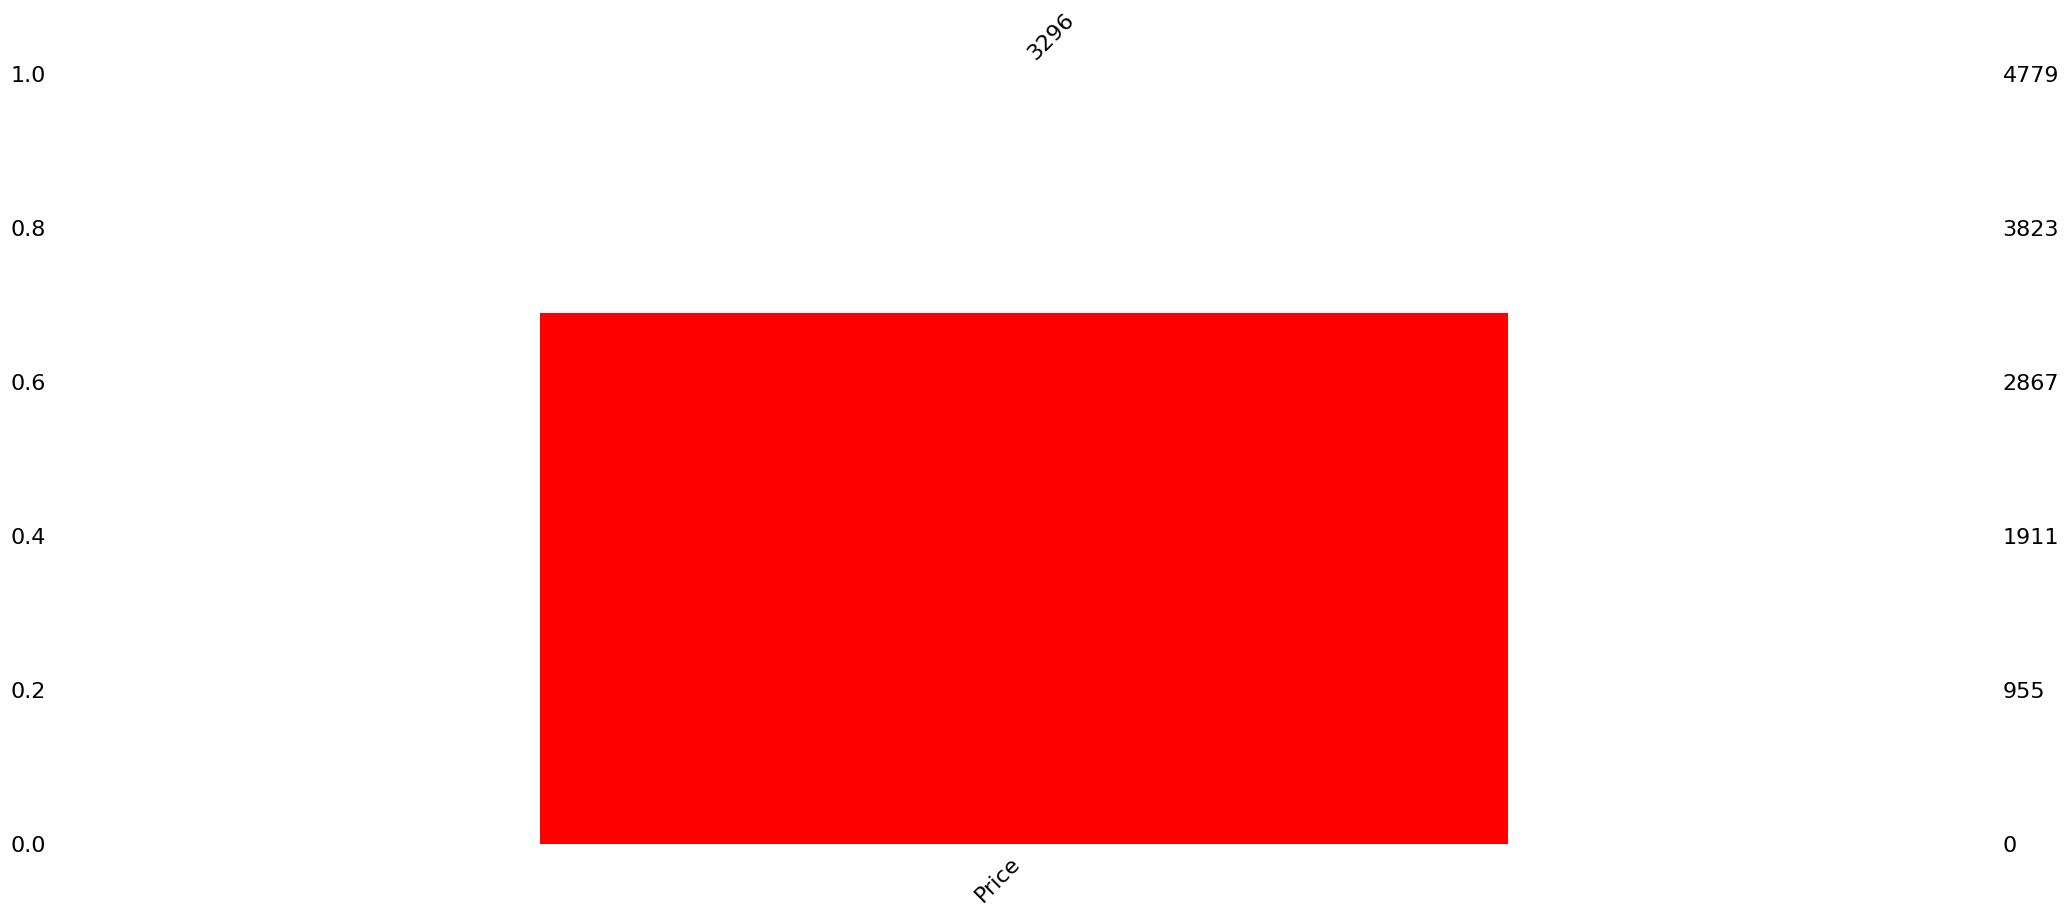

In [8]:
_ = msno.bar(df.resample("D").mean(), color="red")

In [9]:
df.dropna(inplace=True)

In [10]:
# Log-price process
df_log = np.log(df)

In [11]:
HOURS_INDEX = [str(k) for k in list(range(9, 18))]

In [12]:
start_dt = "2019-10-10 09:00:00"
end_dt = "2019-10-10 17:00:00"
data = df[start_dt : end_dt]

TIME_BOUNDARIES = {"MORNING": "09:00:00", "AFTERNOON": "17:00:00"}
get_boundaries_datetimes = lambda day: (day + " " + TIME_BOUNDARIES["MORNING"], day + " " + TIME_BOUNDARIES["AFTERNOON"])

In [13]:
get_boundaries_datetimes("2019-10-09")

('2019-10-09 09:00:00', '2019-10-09 17:00:00')

In [14]:
def get_daily_price_process(day: str = "2018-10-08", process_type: str = "std") -> pd.DataFrame:
    """
    """
    if process_type not in ["std", "log"]:
        raise Exception("The given process parameter is not correct.")
    
    start_dt, end_dt = get_boundaries_datetimes(day)
    assert start_dt != end_dt
    return get_price_process(start_dt=start_dt, end_dt=end_dt, process_type=process_type)

In [15]:
def get_price_process(start_dt: str = "", end_dt: str = "", process_type: str = "std") -> pd.DataFrame:
    """
    Function returning the price process for the given day, with the given process type
    - std = standard (without any transformation)
    - log = log-price process is returned
    """
    if process_type not in ["std", "log"]:
        raise Exception("The given process parameter is not correct.")
    
    assert start_dt != end_dt
    
    if process_type == "std":
        data = df[start_dt : end_dt]
    else:
        data = df_log[start_dt : end_dt]
    
    nb_data = len(data)
    
    if nb_data == 0:
        raise Exception("This day does not contain any trade operations.")
    return data

In [16]:
def plot_price(day: str = "2018-10-08", process_type: str = "std") -> None:
    """
    Function returning the plotting representation of the price
    """

    fig, ax = plt.subplots(figsize=(15, 10))
    
    data = get_daily_price_process(day, process_type=process_type)
    nb_data = len(data)
    start_dt, end_dt = get_boundaries_datetimes(day)

    _ = data.plot(rot=35, ax=ax, color="red")

    t = pd.date_range(start=start_dt,
                  end=end_dt,
                  periods=9)
    _ = ax.set_xticks(t)
    ax.set_xticklabels(HOURS_INDEX)
    
    # Setting title, x and y-labels
    _ = plt.title(rf"Evolution of the price for IVE" 
                  + "\n" 
                  + f"Start: {start_dt} $\longrightarrow$ End: {end_dt}"
                  + "\n"
                  + f"Number of trade operations: {nb_data}")
    _ = plt.xlabel("Intraday hours")
    _ = plt.ylabel("Price of the given security")

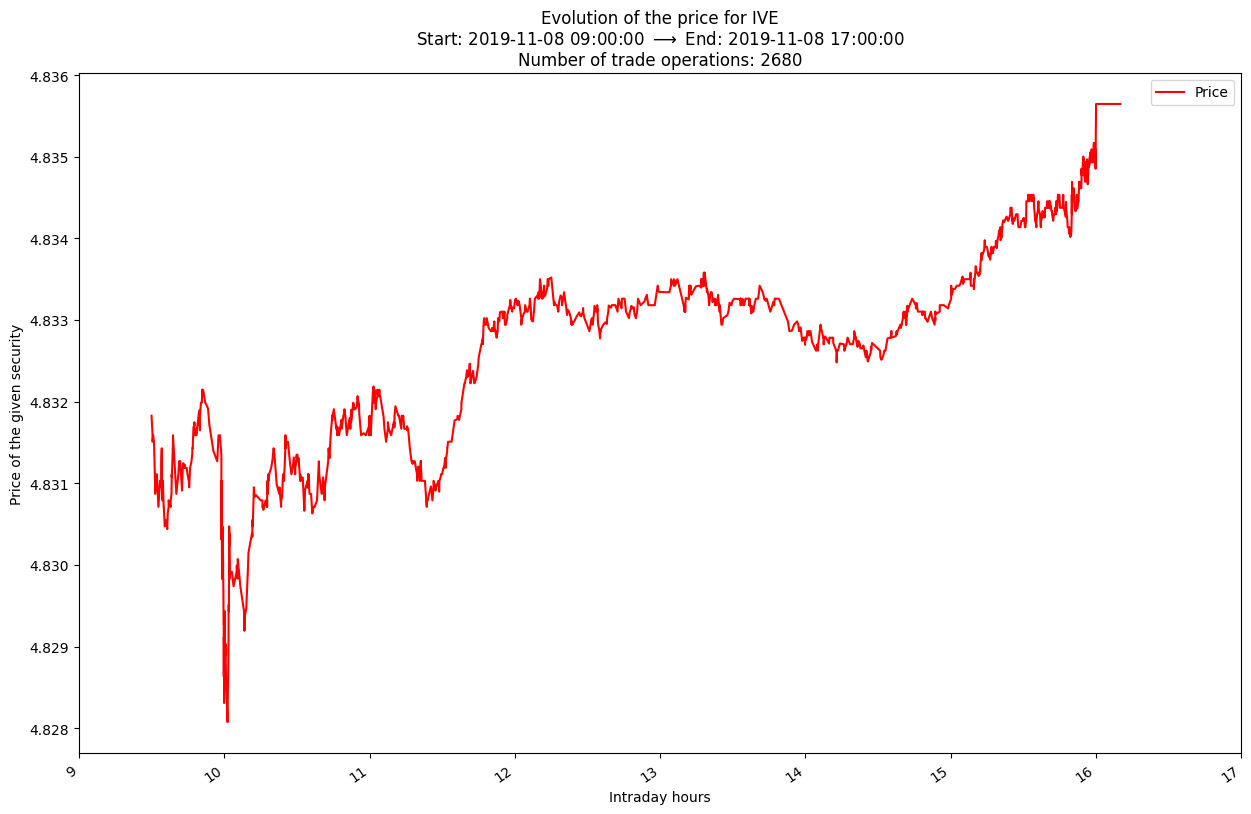

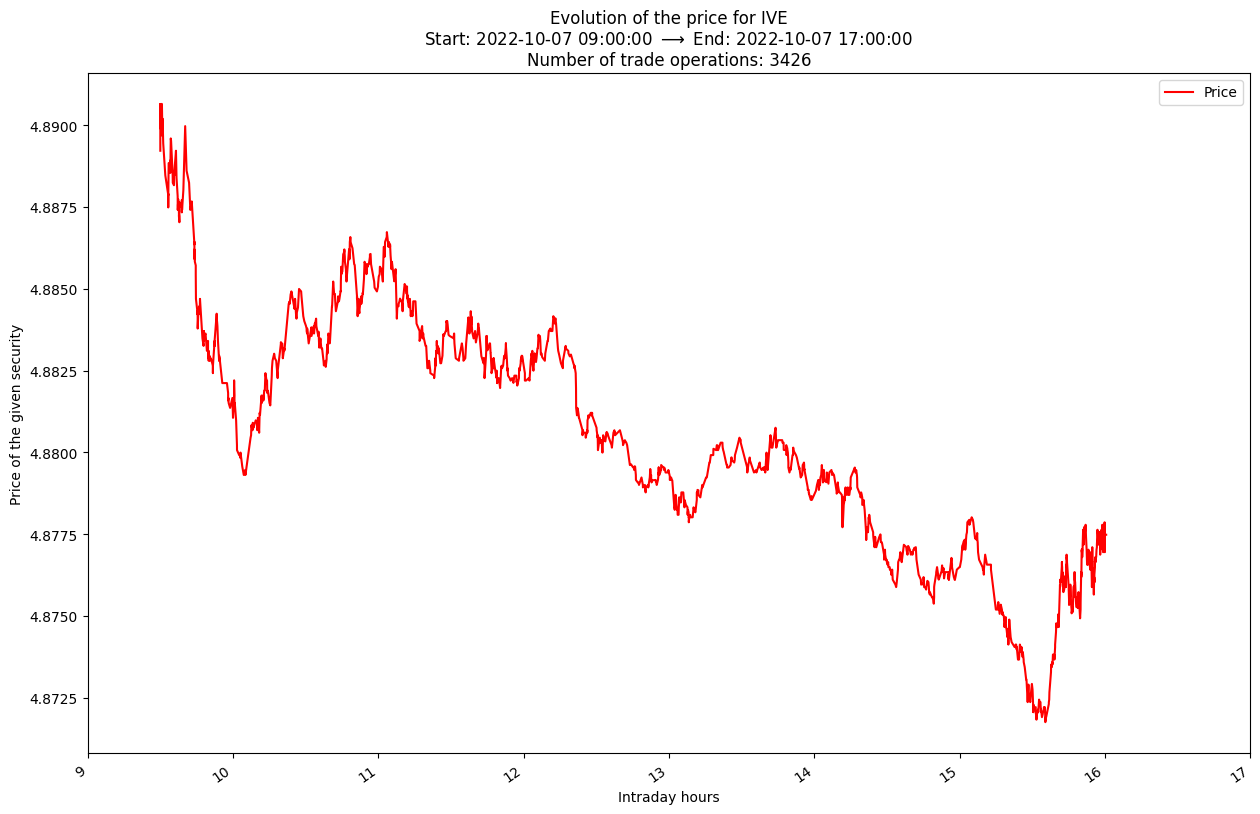

In [17]:
plot_price("2019-11-08", "log")
plot_price("2022-10-07", "log")

After some research, the value of the S&P 500 index is only updated thanks to markets movements from 9:30 to 16:00. However, for plotting reasons, we will keep our actual time range (9:00 to 17:00) in our implementation.

In [18]:
OBSERVATION_FREQS = ["30S", "35S", "40S", "45S", "50S", "1T", "90S", "2T", "150S", "3T", "5T", "8T", "10T", "12T", "15T"]
REAL_NAMES = ["30S", "35S", "40S", "45S", "50S", "1M", "1M30", "2M", "2M30", "3M", "5M", "8M", "10M", "12M", "15M"]

REALIZED_VOL = {freq: 0.0 for freq in OBSERVATION_FREQS}

FIXED_DAY = "2022-01-03"

# Computing the realized volatilities
for freq in OBSERVATION_FREQS:
    print(f"Considered frequency: {freq}")
    
    # Collecting the log-price process
    log_price = get_daily_price_process(day=FIXED_DAY, process_type="log")

    # Resampling
    log_price_resampled = log_price.resample(freq).mean()
    print(f"--> Trade operations: {len(log_price_resampled)}")

    
    # Computing the diff (X_{(i + 1)/n} - X_{(i)/n})
    diff_elements = log_price_resampled.diff()
    
    # Dropping the resulting NaN row
    diff_elements.dropna(inplace=True)
    
    # Computing the square of each difference
    squared_diff_elements = np.square(diff_elements) #diff_elements.applymap(lambda x: x**2)
    
    # Summing all the squared differences
    REALIZED_VOL[freq] = squared_diff_elements.sum()["Price"]

Considered frequency: 30S
--> Trade operations: 801
Considered frequency: 35S
--> Trade operations: 686
Considered frequency: 40S
--> Trade operations: 601
Considered frequency: 45S
--> Trade operations: 534
Considered frequency: 50S
--> Trade operations: 481
Considered frequency: 1T
--> Trade operations: 401
Considered frequency: 90S
--> Trade operations: 267
Considered frequency: 2T
--> Trade operations: 201
Considered frequency: 150S
--> Trade operations: 161
Considered frequency: 3T
--> Trade operations: 134
Considered frequency: 5T
--> Trade operations: 81
Considered frequency: 8T
--> Trade operations: 51
Considered frequency: 10T
--> Trade operations: 41
Considered frequency: 12T
--> Trade operations: 34
Considered frequency: 15T
--> Trade operations: 27


**Remark**: We can observe that the number of trade operations between two different days is not constant and depends on the market participants.

In [19]:
REALIZED_VOL

{'30S': 2.853842257302148e-05,
 '35S': 2.800953221401721e-05,
 '40S': 3.115441323247815e-05,
 '45S': 3.196952524702489e-05,
 '50S': 3.247558817461244e-05,
 '1T': 3.6321434291838745e-05,
 '90S': 3.641572094588038e-05,
 '2T': 3.6890916341098406e-05,
 '150S': 3.6433043085946284e-05,
 '3T': 3.195069404060458e-05,
 '5T': 3.0337405802341726e-05,
 '8T': 2.9267336644928787e-05,
 '10T': 1.9193319273217277e-05,
 '12T': 2.3218518362813882e-05,
 '15T': 2.2064301433026893e-05}

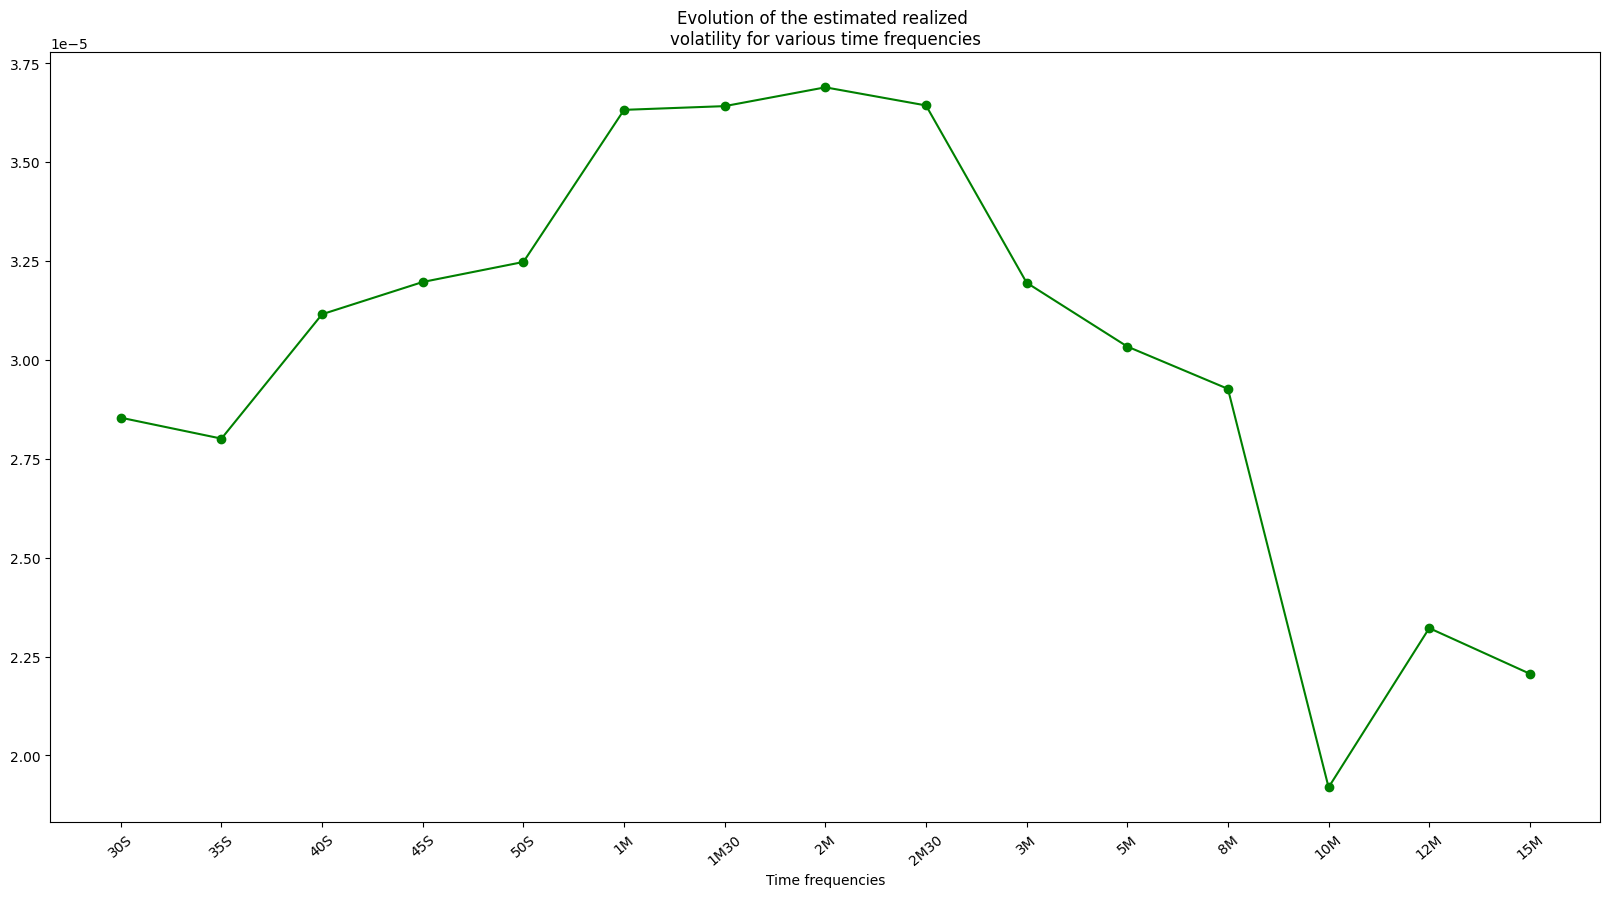

In [20]:
REALIZED_VOL2 = pd.Series(REALIZED_VOL)
plt.figure(figsize=(20, 10))
REALIZED_VOL2.plot(rot=40, marker='o', color="green")
_ = plt.xticks(list(range(len(OBSERVATION_FREQS))), REAL_NAMES)
_ = plt.title("Evolution of the estimated realized \nvolatility for various time frequencies")
_ = plt.xlabel("Time frequencies")

$$
\boxed{\widehat{Q}_n := \sum_{i = 0}^{n - 1} \Big( \widehat{X}_{\frac{i + 1}{n}} - \widehat{X}_{\frac{i}{n}}  \Big)^2}
$$
where:
- $\widehat{X}_{\frac{i + 1}{n}}$ is the log-price in high-frequency, **observed on the market**.
- $n$ is the number of data points at such frequency.
- $\widehat{Q}_n$ is the **estimated realized volatility**.

We now want to compare these results with the long range estimation of the volatility (based on higher period of time); for instance, 1 month of daily data.

In [89]:
# Defining the date limits for the month of January 2022
start_dt = "2022-01-01" + " " + TIME_BOUNDARIES["MORNING"]
end_dt = "2022-02-01" + " " + TIME_BOUNDARIES["AFTERNOON"]

# Getting the respective financial data
monthly_data = get_price_process(start_dt=start_dt, 
                                 end_dt=end_dt, 
                                 process_type="log")

monthly_data_resampled = monthly_data.resample("1D").mean()

# Dropping weekends and holidays (non-trading days)
monthly_data_resampled.dropna(inplace = True)

# Computing the diff (X_{(i + 1)/n} - X_{(i)/n})
diff_elements = monthly_data_resampled.diff()

# Dropping the resulting NaN row
diff_elements.dropna(inplace=True)

# Computing the square of each difference
squared_diff_elements = np.square(diff_elements)

# Summing all the squared differences
squared_diff_elements.sum()["Price"]

0.001931465197074278

## Estimation of $\vartheta$, micro-structure noise size

### Estimation with asymptotical result

We denote $\vartheta$, the micro structure noise size of the market. Our goal is to estimate its value.

As a reminder, we know that:

$$
\frac{1}{n}\widehat{Q}_n \longrightarrow 2\vartheta^2
$$
so, thanks to this theoretical result, we can recover a good estimator of $\vartheta$.

$$
\Longrightarrow \boxed{\vartheta = \lim_{n \rightarrow + \infty} \sqrt{(2n)^{-1}\widehat{Q}_n}}
$$


In order to conduct a small comparison study on this estimation, we will estimate this quantity with the previous values of the **estimated realized volatility** computed in the sections above.

This will help us to study the impact of the observation frequency on the microstructure noise size estimation.

In [22]:
MICROSTRUCT_NOISE_SIZE = {freq: 0.0 for freq in OBSERVATION_FREQS}

for freq in OBSERVATION_FREQS:
    print(f"Considered frequency: {freq}")
    
    # Collecting the log-price process
    log_price = get_daily_price_process(day=FIXED_DAY, process_type="log")

    # Resampling with the observation frequency
    log_price_resampled = log_price.resample(freq).mean()
    
    # Getting the total number of samples
    n = len(log_price_resampled)
    
    # Getting the pre-computed estimated realized volatility
    Qn = REALIZED_VOL[freq]
    
    # Computing and storing the microstructure noise size estimation
    MICROSTRUCT_NOISE_SIZE[freq] = np.sqrt(1/(2*n)*Qn)

Considered frequency: 30S
Considered frequency: 35S
Considered frequency: 40S
Considered frequency: 45S
Considered frequency: 50S
Considered frequency: 1T
Considered frequency: 90S
Considered frequency: 2T
Considered frequency: 150S
Considered frequency: 3T
Considered frequency: 5T
Considered frequency: 8T
Considered frequency: 10T
Considered frequency: 12T
Considered frequency: 15T


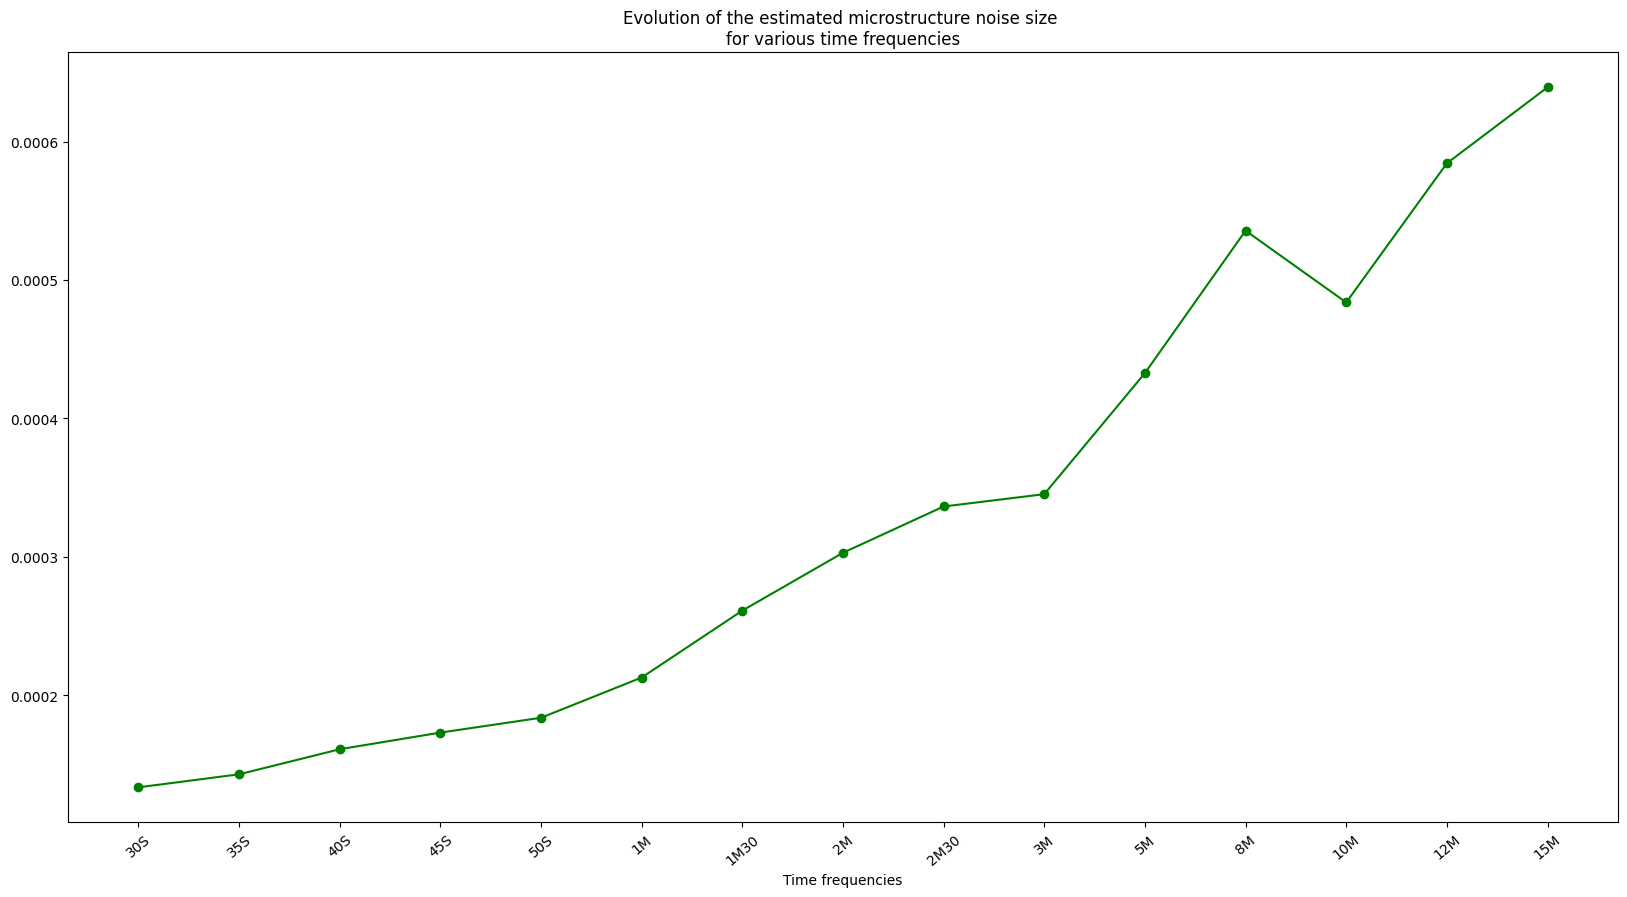

In [90]:
MICROSTRUCT_NOISE_SIZE2 = pd.Series(MICROSTRUCT_NOISE_SIZE)
plt.figure(figsize=(20, 10))
MICROSTRUCT_NOISE_SIZE2.plot(rot=40, marker='o', color="green")
_ = plt.xticks(list(range(len(OBSERVATION_FREQS))), REAL_NAMES)
_ = plt.title("Evolution of the estimated microstructure noise size \nfor various time frequencies")
_ = plt.xlabel("Time frequencies")

### Estimation with autocorrelation between the returns at different scales

In [24]:
def autocorrelation(data, lag: int = 1) -> float:
    """
    Function computing and returning the autocorrelation value
    """
    return data.autocorr(lag = lag)

def autocovariance(data, lag: int = 1) -> float:
    """
    Function computing and returning the autocovariance value
    """
    return autocorrelation(data, lag = lag) * data.var()

In [92]:
# Testing the functions
print(autocovariance(df["Price"], lag = 1))
print(autocorrelation(df["Price"], lag = 1))
print(autocovariance(df["Price"], lag = 2000))

752.1409633231028
0.9999990617613697
751.7899615722935


In [105]:
log_returns = df_log["Price"].diff()
log_returns.dropna(inplace=True)

In [106]:
autocovariance(data=log_returns, lag=1)

-2.9624944838091778e-06

In [108]:
NOISE_SIZE = abs(autocovariance(data=log_returns, lag=1))
print(f"Microstructure noise size: {NOISE_SIZE}")

Microstructure noise size: 2.9624944838091778e-06


**Assumption**: $(\varepsilon_{\frac{i}{n}})_{i \in \lbrace 0 \ldots n\rbrace}$ is an iid sequence $\mathcal{N}(0, 1)$.


So, we have $\mathbf{Var}(\varepsilon_{\frac{i}{n}}) = 1$.

### ACF plotting

In [84]:
a = df_log["Price"].resample("D").mean()
a = a.diff()
a.dropna(inplace=True)
b = a.to_numpy()

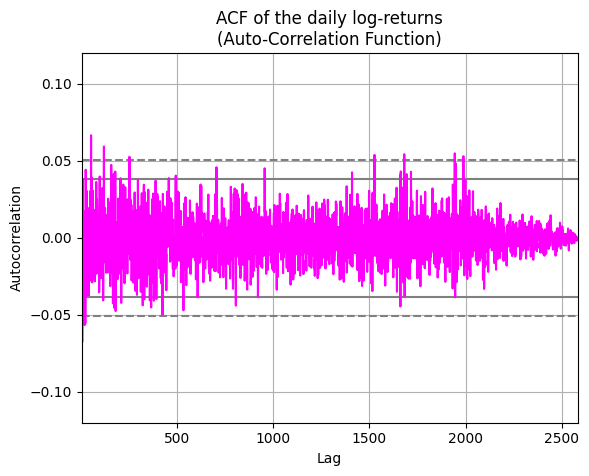

In [85]:
x = pd.plotting.autocorrelation_plot(a, color="magenta")
x.plot()
plt.ylim([-0.12, 0.12])
_ = plt.title("ACF of the daily log-returns\n(Auto-Correlation Function)")

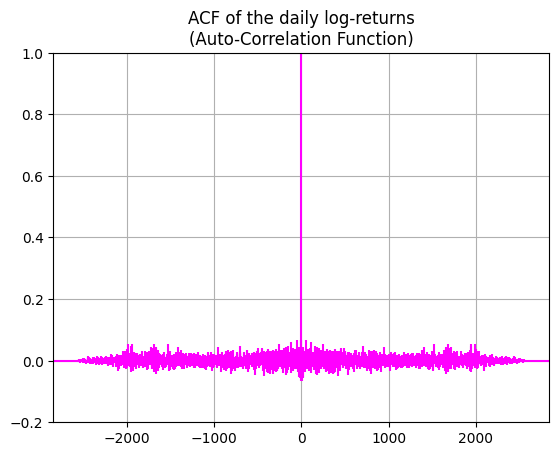

In [86]:
_ = plt.acorr(a, maxlags= 2583, color="magenta")
_ = plt.ylim([-0.2, 1])
_ = plt.grid()
_ = plt.title("ACF of the daily log-returns\n(Auto-Correlation Function)")

---

**Lucas RODRIGUEZ**